# Analyze Tweet Data
## Part 2: Exploratory Data Analysis (EDA) and Data Visualization

## Table of Contents
- [Introduction](#intro)
- [EDA and Visualization](#analysis)
- [Conclusion](#conclusion)

<a id='intro'></a>
## Introduction
The three datasets collected, assessed, cleaned, and stored from __Part 1: Data Wrangling__ were analyzed to generate insights on four key topics listed below.
1. Time of the Day when _WeRateDogs (@dogrates)_ Shows Most Activity
2. Correlation between Favorite Counts and Retweet Counts
3. Comparison of Dog Ratings and Sentiment of Tweets
4. Accuracy and Precision of Predicting Dogs' Breeds from Images

The roles of the various analytical methods used in this part of the project can be divided into two main categories, _Explore_ and _Feature Engineering_. Exploring the cleaned datasets provided motivations for investigating the four topics listed above. Feature engineering improved the cleaned datasets and streamlined the application of various analytical methods for generating insights from both statistics which quantitatively summarize the data and plots which visually present patterns in the data. 

The next section describes in detail how various analytical methods relevant to each topic were applied to computing meaningful statistics and aims to demonstrate how the overall process of generating meaningful insights rely on efficient organization and arrangement of data, a task which is only feasible after successful wrangling of data.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import copy
import statsmodels.api as sm
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid', {'grid.linestyle': 'dotted'})

<a id='analysis'></a>
## EDA and Visualization
Three `.csv` files containing the cleaned version of the data from __Part 1: Data Wrangling__ were imported to this notebook by using pandas.

In [2]:
# read .csv files containing cleaned data
df_archive = pd.read_csv('data/twitter_archive_clean.csv')
df_master = pd.read_csv('data/twitter_archive_master.csv')
df_image = pd.read_csv('data/image_prediction_clean.csv')

### Data Wrangling
Assessment of the three datasets imported above revealed that the data types of the `tweet_id` columns in all these datasets and the `timestamp` column in the two Twitter Archive datasets were integer and string (object), respectively. Although the data types of `tweet_id` and `timestamp` had been changed to string (object) and datetime, respectively, as documented in the data wrangling efforts from Part 1, the data types of these two columns may have been reverted as a result of reading the cleaned data from the `.csv` files with pandas.

A sequence of steps similar to the one used in Part 1, _define_, _code_, and _test_, was used to change the data types of the `tweet_id` and `timestamp` columns back to string (object) and datetime, respectively, as shown in the code block below.

In [3]:
# correct data types of selected columns
df_list = [df_archive, df_master, df_image]
df_name = ['twitter_archive_clean.csv', 'twitter_archive_master.csv', 'image_prediction_clean.csv']

for i in range(len(df_list)):
    # columns with data types reverted back to those from uncleaned version
    col1 = df_list[i].columns[0] # tweet_id
    col2 = df_list[i].columns[1] # timestamp
    
    # data type of the column from uncleaned version
    col1_type = df_list[i][col1].dtype
    col2_type = df_list[i][col2].dtype
    
    # .csv file name
    print('{}. Dataframe: {}'.format(i+1, df_name[i]))
    
    # change data type (of tweet_id) to string
    df_list[i][col1] = df_list[i][col1].astype(dtype = 'str')
    
    # column name: data type before/after
    print('  - {}: from "{}" to "{}"'.format(col1, col1_type, df_list[i][col1].dtype))
    
    if i != 2: # df_image does not have timestamp column
        # change data type (of timestamp) to string
        df_list[i][col2] = pd.to_datetime(arg = df_list[i][col2])

        # column name: data type before/after
        print('  - {}: from "{}" to "{}"'.format(col2, col2_type, df_list[i][col2].dtype))

1. Dataframe: twitter_archive_clean.csv
  - tweet_id: from "int64" to "object"
  - timestamp: from "object" to "datetime64[ns, UTC]"
2. Dataframe: twitter_archive_master.csv
  - tweet_id: from "int64" to "object"
  - timestamp: from "object" to "datetime64[ns, UTC]"
3. Dataframe: image_prediction_clean.csv
  - tweet_id: from "int64" to "object"


### 1. Time of the Day when _WeRateDogs (@dogrates)_ Shows Most Activity
#### Explore
A subset of the data contained in the dataframe object `df_archive` was obtained by filtering the data for the timestamps of the original tweets. In this subset, two new columns were created, one for the hour part and another for the day part of the date and time data. 
* The numbers of original tweets posted in each hour on each day of the week suggested that the account regularly posted tweets during certain hours on each day. On Mondays, for example, the original tweets were posted mainly during the two time periods, four hours starting from around midnight and three hours starting from three in the afternoon.
* Also, although the total number of original tweets from each day of the week diminished as the week progressed from Monday, the differences in the counts of tweets between two days did not appear to be significant.

These two observations motivated the investigation of the time of the day when the Twitter account shows most activity and how the trend from one day compares with the trends from other days of the week.

In [4]:
# sub-dataset for timestamps of original tweets
df_1 = df_archive.query('retweet == False')[['timestamp']]

# hour and day parts of timestamps
df_1['hour'] = df_1.timestamp.dt.hour
df_1['day'] = df_1.timestamp.dt.weekday

# number of original tweets in each hour on day 0 (Mondays)
df_1.groupby('day').hour.value_counts()[0]

hour
0     46
1     46
16    39
3     35
2     34
17    30
15    28
23    23
18    15
4     14
19    12
20    11
21    11
22     8
5      2
14     2
13     1
Name: hour, dtype: int64

In [5]:
# total number of original tweets from each day of a week
df_1.groupby('day').hour.agg('count')

day
0    357
1    326
2    322
3    305
4    305
5    284
6    276
Name: hour, dtype: int64

#### Feature Engineering
To allow for the comparison of Twitter activity during the same hour on each day, the activity was defined as the percentage of original tweets posted during an hour-long period on a given day of the week. This quanitity which was computed by dividing the number of tweets posted in each hour on a given day by the total number of tweets from that day was stored in the new column, `tweet_percentage`.

In [6]:
# percentage of original tweets from each hour on a given day of the week
df_1 = df_1.groupby('day').hour.value_counts() / df_1.groupby('day').hour.agg('count') * 100
df_1 = pd.DataFrame(df_1).rename(columns = {'hour':'tweet_percentage'})

# reset multi-index
df_1.reset_index(level = ['day','hour'], inplace = True)

df_1.head()

,day,hour,tweet_percentage
0,0,0,12.885154
1,0,1,12.885154
2,0,16,10.924370
3,0,3,9.803922
4,0,2,9.523810


Because no tweet was posted during several hours of each day, these hours were not recoreded in the dataframe object `df_1`. To allow for the plotting of the percentages for all 24 hours of each day, these hours without any Twitter activity were added to the dataframe.

In [7]:
# index to which new row can be added
ind = df_1.index.max() + 1

# daily hours available: 0, 1, ..., 22, 23
hours = [hour for hour in range(24)]

# if the hour is not recorded in the dataframe for given day
for d in df_1.day.unique():
    for hr in hours:
        if hr not in df_1.query('day == @d').hour.unique():
            
            # add new row with day, hour, and 0 percentage of tweet-posting activity
            df_1.loc[ind] = d, hr, 0
            
            # update index for the next row addition
            ind += 1

df_1.tail()

,day,hour,tweet_percentage
163,6,10,0.0
164,6,11,0.0
165,6,12,0.0
166,6,13,0.0
167,6,14,0.0


In [8]:
# sort values by three columns and reset index
df_1.sort_values(by = ['day', 'hour', 'tweet_percentage'], inplace = True)
df_1.reset_index(drop = True, inplace = True)

df_1.head()

,day,hour,tweet_percentage
0,0,0,12.885154
1,0,1,12.885154
2,0,2,9.523810
3,0,3,9.803922
4,0,4,3.921569


Before creating a bar plot for each day of the percentages of tweets in each hour, a dictionary which maps the seven integer values of the `day` column to their corresponding names of the day was created as shown below.

In [9]:
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow = [day for day in np.arange(7)] # integers representing days of a week

# dictionary mapping integers to days of a week
dow_dict = {}
for key in dow:
    # integer: day of week (ex 0: Monday)
    dow_dict[key] = day_of_week[key]

According to the bar plots shown below, the trends in posting tweets throughout the 24 hourly increments of each day have two modes. 
* _WeRateDogs_ showed the most frequent activity or posted tweets most frequently during the first two-hour period from midnight from Monday to Sunday. The hourly percentage of tweets during this period ranges from 12% to 16%, nearly three to four times the average of 4.17%.
* Also, except on Sunday, the account showed the most frequent activity or posted tweets most frequently during the two-hour period from 16 to 18. The hourly percentage of tweets during this period ranges from 8% to 11%, nearly two to three times above the average. On Sunday, the second mode was observed on the last hour of the day, showing an hourly percentage of tweets of 10%.

From Monday to Sunday, the account showed the least or no activity during the approximately 10-hour time period from 5 to 15.

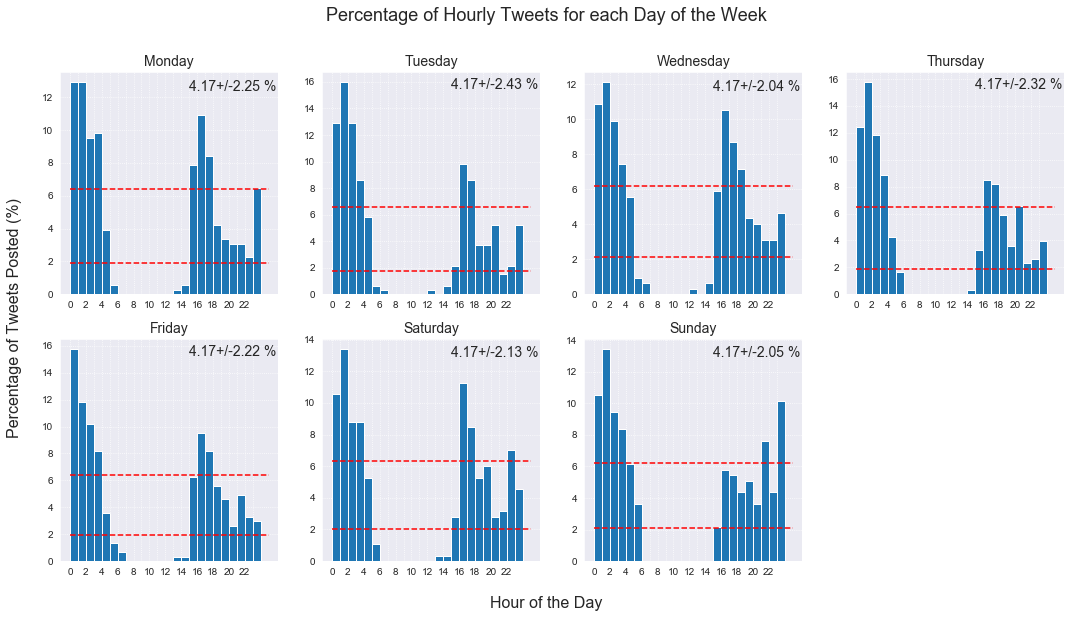

In [10]:
# create figure with 2-by-4 subplots
rows = 2
cols = 4
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (18,9))

# add figure title and common x, y axes labels for all subplots
fig.suptitle('Percentage of Hourly Tweets for each Day of the Week', fontsize = 18)
fig.text(x = 0.5, y = 0.06, s = 'Hour of the Day', ha = 'center', va = 'center', fontsize = 16)
fig.text(x = 0.09, y = 0.5, s = 'Percentage of Tweets Posted (%)', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 16)

# for each subplot, ax[row, col]
for row in np.arange(rows):
    for col in np.arange(cols):
        
        if row == 0: # in first row, col number = integer for the given day
            df = df_1.query('day == @col') # filter data for the given day
            day_name = dow_dict[col] # find name of the day
            
        else:
            # delete last (eighth) subplot because there is only seven days in a week
            if col == cols - 1:
                fig.delaxes(ax[row, col])
                break
            
            # in second row, col number = integer for the given day - 4
            df = df_1.query('day == @col + 4')
            day_name = dow_dict[col + 4]

        # set up xtick locations and labels
        width = 2
        x_loc = list(df.hour * width)
        labels = [label for label in np.arange(24)]
        
        # bar plots for percentage of hourly tweets for each day of week
        ax[row, col].bar(x = x_loc, height = df.tweet_percentage, width = width, align = 'edge')
        
        # label suplot with name of the day
        ax[row, col].set_title(day_name, fontsize = 14)
        
        # label xticks by increments of two: 0, 2, ..., 22
        for i in range(len(labels)):
            if labels[i] % 2 != 0:
                labels[i] = ''
        
        # add xtick labels to the subplot
        ax[row, col].set_xticks(ticks = x_loc)
        ax[row, col].set_xticklabels(labels = labels)
        
        # statistics for percentages of tweets across hours in a given day
        avg = df.tweet_percentage.mean()
        sd = df.tweet_percentage.std()
        lower = avg - sd/2
        upper = avg + sd/2
        
        # horizontal lines for mean percentage +,- standard deviation/2
        ax[row, col].hlines(y = lower, xmin = 0, xmax = 50, colors = 'red', linestyles = '--')
        ax[row, col].hlines(y = upper, xmin = 0, xmax = 50, colors = 'red', linestyles = '--')
        
        # legend for statistics
        ax[row, col].text(x = 30, y = df.tweet_percentage.max()-0.5, s = '{}+/-{} %'.format(round(avg, 2), round(sd/2, 2)), fontsize = 14)

Note that for all seven days, the mean percentage of hourly tweets is approximately 4.17% because of dividing 100% by 24-hour increments. A box plot of the distribution of these percentages of hourly tweets was created for each day to streamline the comparison of the distribution across days.

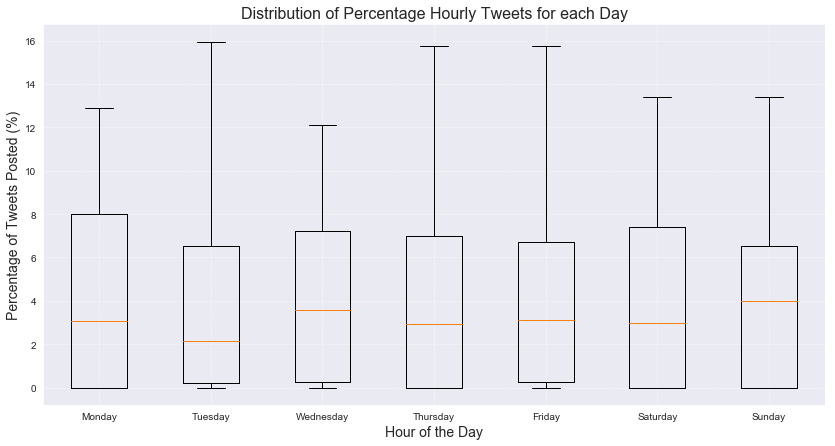

In [11]:
# five percentiles for percentages of hourly tweets
percentile_list = []

for day in df_1.day.unique():
    df = df_1.query('day == @day').tweet_percentage
    
    # one list of percentiles for each day's data
    percentile_list.append(np.percentile(df, [0,25,50,75,100]).tolist())

# box plot of distribution for percentages of hourly tweets
plt.figure(figsize = (14, 7))
plt.boxplot(x = percentile_list)

# change xticks from integers to names of the days
plt.xticks(np.arange(len(day_of_week))+1, day_of_week)

# add title and axis labels
plt.title('Distribution of Percentage Hourly Tweets for each Day', fontsize = 16)
plt.xlabel('Hour of the Day', fontsize = 14)
plt.ylabel('Percentage of Tweets Posted (%)', fontsize = 14);

As observed in the previous bar plots, the box plots for all seven days show a minimum percentage of hourly tweet posts of 0% because on several hourly increments, the account did not post any tweets. The interquartile range of approximately 8% on Monday is the largest, whereas the interquartile range of approximately 6% on Tuesday is the smallest among the seven days of the week. Throughout the seven days, the median of the percentages ranges from 2% to 4%. The maximum percentage of hourly tweet posts of approximately 16% which was observed on Tuesday, Thursday, and Friday was the largest among the seven days. These three days showed the largest range of percentage values as well, a trend also suggested by the standard deviations of the percentages for Tuesday, Thursday, and Friday which were largest among all seven days.

### 2. Correlation between Favorite Counts and Retweet Counts
#### Explore
The distribution of each variable, favorite counts and retweet counts, was explored by applying the `describe()` method from Pandas to the two columns, `favorite_count` and `retweet_count`, in the dataframe object `df_master`.

In [12]:
# distribution of favorite counts
df_master.favorite_count.describe()

count      2339.000000
mean       7883.799914
std       12218.843384
min           0.000000
25%        1365.000000
50%        3428.000000
75%        9653.500000
max      162744.000000
Name: favorite_count, dtype: float64

In [13]:
# distribution of retweet counts
df_master.retweet_count.describe()

count     2339.000000
mean      2897.751176
std       4886.545185
min          1.000000
25%        582.500000
50%       1353.000000
75%       3377.500000
max      82836.000000
Name: retweet_count, dtype: float64

The quantitative analysis above showed a right-skewed distribution for both variables in which the median lies to the left of the mean. Considering the potential application of the counts of favorite and retweet for understanding the popularity of the corresponding tweet, the distributions of these two variables must be right-skewed; in other words, large numbers of favorite counts and retweet counts are less likely to be observed than smaller numbers. If the distributions of both the favorite counts and the retweet counts are right-skewed, then what are the direction and the magnitude of the correlation between these two variables?

In [14]:
# five most frequently observed favorite counts
df_master.favorite_count.value_counts().sort_values(ascending = False).head()

0       167
2455      3
1661      3
1428      3
1433      3
Name: favorite_count, dtype: int64

In [15]:
# distribution of retweet counts with a favorite count of 0
df_master.query('favorite_count == 0').retweet_count.describe()

count      167.000000
mean      6604.550898
std       6325.342307
min         23.000000
25%       2515.000000
50%       5367.000000
75%       8284.000000
max      39718.000000
Name: retweet_count, dtype: float64

Preliminary investigation of this correlation revealed that 167 data points had a favorite count of 0 but retweet counts which vary from 23 to 39,718. This observation motivated the need for the analysis of two sets of favorite count and retweet count pairs: one including and another excluding the favorite count of 0.

#### Feature Engineering
To streamline the visualization of the correlation between the favorite counts and the retweet counts for two sets of data pairs, the following functions were defined, one for creating a scatter plot and another for calculating the correlation coefficient and annotating the value in the scatter plot. These custom functions were used to create two scatter plots for retweet counts vs. favorite counts and display the correlation coefficient of the two variables in each plot.

In [16]:
# scatter plot of retweet vs. favorite counts
    # default values of the arguments are specified for the (x, y) data pair filtered by favorite counts above 0
def scatter_plot(df_x = df_master.query('favorite_count > 0').favorite_count
                 , df_y = df_master.query('favorite_count > 0').retweet_count
                 , color = 'b'
                 , size = 25):
    
    # add scatter plot to a subplot indexed with the variable "col"
    return ax[col].scatter(x = df_x
                           , y = df_y
                           , c = color
                           , s = size
                           , marker = 'o', edgecolors = 'black')

# annotation
def text(df_x, df_y):
    # correlation coefficient for x and y variables
    corr = np.corrcoef(x = df_x, y = df_y)[0, 1]
    
    # annotate the col-th subplot with the value of the correlation coefficient
    return ax[col].text(x = df_x.min()
                        , y = df_y.max()
                        , s = 'Correlation Coefficient: {}'.format(round(corr, 3))
                        , fontsize = 14)

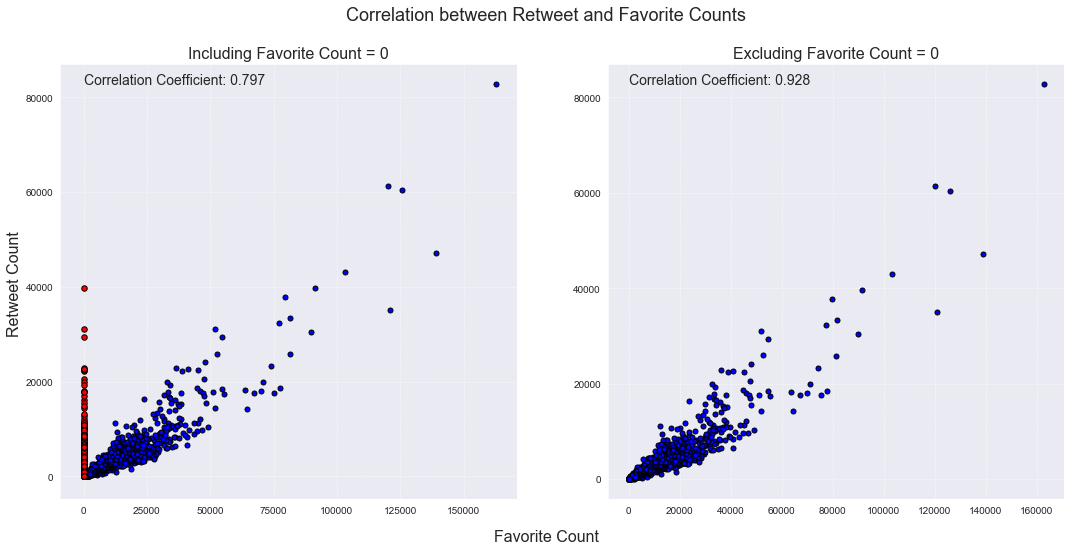

In [17]:
# create a figure with subplots arranged in 1-by-2
rows = 1
cols = 2
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (18,8))

# add figure title and axis labels for both subplots
fig.suptitle('Correlation between Retweet and Favorite Counts', fontsize = 18)
fig.text(x = 0.5, y = 0.06, s = 'Favorite Count', ha = 'center', va = 'center', fontsize = 16)
fig.text(x = 0.09, y = 0.5, s = 'Retweet Count', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 16)

for col in np.arange(cols):
    # create scatter plot excluding favorite count 0
    scatter_plot()
    
    # to the first subplot
    if col == 0:
        
        # add data points with favorite count 0
        scatter_plot(df_x = df_master.query('favorite_count == 0').favorite_count
                     , df_y = df_master.query('favorite_count == 0').retweet_count
                     , color = 'r'
                     , size = 30)
        
        # annotate correlation coefficient for the data pairs including favorite count 0
        text(df_x = df_master.favorite_count
             , df_y = df_master.retweet_count)
        
        # add subplot title
        ax[col].set_title('Including Favorite Count = 0', fontsize = 16)
    
    # to the second subplot
    else:
        
        # annotate correlation coefficient for the data pairs excluding favorite count 0
        text(df_x = df_master.query('favorite_count > 0').favorite_count
             , df_y = df_master.query('favorite_count > 0').retweet_count);
        
        # add subplot title
        ax[col].set_title('Excluding Favorite Count = 0', fontsize = 16)

The scatter plot to the right excludes the data points with a favorite count of 0, which are indicated in red in the scatter plot to the left. Excluding these data points strengthened the positive relationship between the favorite counts and retweet counts and increased the correlation coefficient from 0.797 to 0.928. Although the favorite counts and the retweet counts did not correlate in some tweets, these tweets did not significantly weaken the strong, positive correlation between the favorite counts and the retweet counts of all tweets included in the Twitter Archive. In other words, a _popular_ tweet with a large number of favorite counts (or retweet counts) is expected to have a relatively large number of retweet counts (or favorite counts). This observation, however, does not necessarily suggest any causal relationship between these two counts.

The strong, positive correlation between the favorite counts and retweet counts and the increase in this correlation rendered by removing _outliers_ motivated the application of linear regression to test and confirm the observations made from the scatter plots above. Similar to the two scatter plots, two linear regressions were applied to the favorite counts, the predictor variable, and the retweet counts, the response variable: one for the data points including favorite count of 0 and another which excludes data points with favorite count of 0.

In [18]:
# predictor and response pairs with favorite count 0
df_2 = df_master[['retweet_count', 'favorite_count']]

# add a new column for y-intercept
df_2 = df_2.copy()
df_2['intercept'] = 1

# OLS
lm = sm.OLS(df_2['retweet_count'], df_2[['intercept', 'favorite_count']]) # linear modeling with OLS: y-var, x-var
results = lm.fit() # apply the best fit
results.summary() # summary of linear modeling

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     4075.
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:57:03   Log-Likelihood:                -22006.
No. Observations:                2339   AIC:                         4.402e+04
Df Residuals:                    2337   BIC:                         4.403e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        384.3091     72.615      5.292      0.000     241.912     526.706
favorite_count     0.3188      0.005     63.833      0.000       0.309       0.329
==============================================================================
Omnibus:                     2444.074   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           174046.682
Skew:                           5.117   Prob(JB):                         0.00
Kurtosis:                      44.002   Cond. No.                     1.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# predictor and response pairs without favorite count 0
df_2_subset = df_2.query('favorite_count > 0')

# OLS
lm = sm.OLS(df_2_subset['retweet_count'], df_2_subset[['intercept', 'favorite_count']]) # linear modeling with OLS: y-var, x-var
results = lm.fit() # apply the best fit
results.summary() # summary of linear modeling

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 1.338e+04
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        19:57:03   Log-Likelihood:                -19279.
No. Observations:                2172   AIC:                         3.856e+04
Df Residuals:                    2170   BIC:                         3.857e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       -315.5487     44.987     -7.014      0.000    -403.770    -227.327
favorite_count     0.3449      0.003    115.678      0.000       0.339       0.351
==============================================================================
Omnibus:                     1832.946   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           203717.181
Skew:                           3.368   Prob(JB):                         0.00
Kurtosis:                      49.964   Cond. No.                     1.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing the data points with favorite count of 0 increased the __R-squared__ value from 0.636 to 0.860. Thus, removing the _outliers_ strengthened the capability of the predictor variable to forecast the response variable in that the proportion of the change in the response variable which could be accounted for by the predictor variable increased by 22.4% after the _outliers_ were removed.

### 3. Comparison of Dog Ratings and Sentiment of Tweets
#### Explore
Tweets posted by _WeRateDogs (@dogrates)_ not only provide comments on the images of dogs but include ratings of dogs out of 10. As observed during the data wrangling phase, these ratings are unique in that the scores may be greater than 1; that is, the numerator may be larger than 10. One would expect that the images of dogs with higher ratings would be associated with noteworthy qualities. This expectation motivated the investigation of whether the qualities which rendered the assigned ratings are reflected in the sentiment of the tweets.

The `textblob` package was used for analyzing the sentiment of the tweets posted by _WeRateDogs (@dogrates)_. The `sentiment` property of a `TextBlob`, both of which are explained in the following discussions, returns a _polarity_ score for the tweet used to create the `TextBlob`. This score ranges from -1.0 for most negative sentiment to 1.0 for most positive sentiment. To ensure that the dog ratings are comparable with this scoring scheme, both the distribution of the values for the `rating_numerator` and the number of occurrences of each unique value were obtained as shown below.

In [20]:
# distribution of ratings
df_archive.rating_numerator.describe()

count    2356.00000
mean       12.15365
std        40.83416
min         0.00000
25%        10.00000
50%        11.00000
75%        12.00000
max      1776.00000
Name: rating_numerator, dtype: float64

In [21]:
# number of occurrences of each rating
df_archive.rating_numerator.value_counts().sort_values(ascending = False)

12      558
11      464
10      462
13      353
9       157
8       102
14       56
7        54
5        37
6        32
3        19
0        18
4        15
2         9
1         8
75        2
420       2
15        2
17        1
26        1
182       1
27        1
1776      1
666       1
Name: rating_numerator, dtype: int64

#### Feature Engineering
Based on the analysis of the values for `rating_numerator`, values below 11, those below 13, and the remaining values were assigned a `rating` of _low_, _medium_, and _high_, respectively. Note that the dataset used for this sentiment analysis was obtained by extracting the `text` and `rating_numerator` data of the original tweets from the Twitter Archive.

In [22]:
# original tweets' text and rating_numerator
df_3 = df_archive.query('retweet == False')[['text', 'rating_numerator']].reset_index(drop = True)

# assign a rating of low, medium, or high based on rating_numerator
def rate(df):
    if df.rating_numerator < 11:
        return "low"
    elif df.rating_numerator < 13:
        return "medium"
    else:
        return "high"

df_3 = df_3.copy()
df_3['rating'] = df_3.apply(rate, axis = 1)

As briefly introduced in the previous section, each text data of the original tweet was used to create a `TextBlob` and obtain the polarity score, the first element of the `sentiment` property. The polarity score of each original tweet was first stored in a list, assigned to a dictionary key, and then joined with the dataframe object created for this sentiment analysis. Finally, histogram plots of the polarity scores for each dog ratings, _low_, _medium_, and _high_, were created and are presented below along with the median of the polarity scores for each dog ratings.

In [23]:
# empty dictionary for storing a list of polarity score of each original tweet
sentiment_dict = {}
sentiment_dict['sentiment'] = [TextBlob(tweet).sentiment[0] for tweet in df_3.text]

# join the polarity score of each original tweet to the text, rating_numerator, and rating data
df_3 = df_3.join(other = pd.DataFrame(data = sentiment_dict))

df_3.head()

,text,rating_numerator,rating,sentiment
0,This is Phineas. He's a mystical boy. Only eve...,13,high,0.000000
1,This is Tilly. She's just checking pup on you....,13,high,0.366667
2,This is Archie. He is a rare Norwegian Pouncin...,12,medium,0.150000
3,This is Darla. She commenced a snooze mid meal...,13,high,0.500000
4,This is Franklin. He would like you to stop ca...,12,medium,0.233333


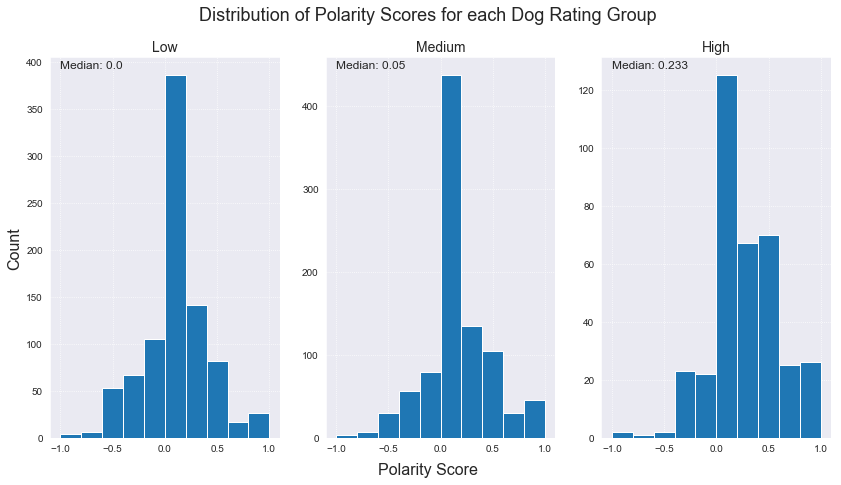

In [24]:
# create a figure with subplots arranged in 1-by-3
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 7))

# add figure title and axis labels for all subplots
fig.suptitle('Distribution of Polarity Scores for each Dog Rating Group', fontsize = 18)
fig.text(x = 0.5, y = 0.06, s = 'Polarity Score', ha = 'center', va = 'center', fontsize = 16)
fig.text(x = 0.09, y = 0.5, s = 'Count', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 16)

# dictionary of ratings and integers for indexing subplots
rating_dict = {'low': 0, 'medium': 1, 'high': 2}

for key in rating_dict:
    # set rating as subplot title 
    ax[rating_dict[key]].set_title(key.title(), fontsize = 14)
    
    # plot histogram of the polarity scores for the given rating
    ax[rating_dict[key]].hist(df_3.query('rating == @key').sentiment)
    
    # compute and display the median of the polarity scores for the given rating
    median = df_3.query('rating == @key').sentiment.median()
    ax[rating_dict[key]].text(x = -1, y = ax[rating_dict[key]].get_ylim()[1] * 0.97
                              , s = 'Median: {}'.format(round(median, 3)), fontsize = 12);

Comparison of the histograms shows that the center of the distribution of polarity scores increases with the dog rating from 0 for _low_ to 0.05 for _medium_ and 0.233 for _high_. However, this increase across each group of dog rating appears to be insignificant relative to the range of polarity scores from -1.0 to 1.0 as defined in the `textblob` package. The gap between the dog ratings and the sentiment of the original tweets can be attributed to two factors.
* First, unlike polarity scores which can take any numeric values from -1.0 to 1.0, the interquartile range of the values of  `rating_numerator` is limited to only three integers 10, 11, and 12. This outcome of the human-generated rating schema suggests its inherent limitations in quantifying a wide variety of qualities associated with the images of dogs.
* Second, the numeric ratings included in the original tweets are not necessarily correlated with the tone of the comments of the dogs' images. Thus, the polarity score assigned to a `TextBlob` of an original tweet may estimate the sentiment of the comment but still not align with the rating assigned to the dog's image.

Given wide and evenly distributed ratings of dogs and comments with tone commensurate with the ratings, one may assume that the center of the distribution of polarity scores for _low_, _medium_, and _high_ ratings of dog would be closer to -1.0, 0.0, and 1.0, respectively.

### 4. Accuracy and Precision of Predicting Dogs' Breeds from Images
#### Explore
As mentioned in __Part 1: Data Wrangling__, the images of dogs included in the tweets from the enhanced Twitter archive were run through a [neural network](https://www.youtube.com/watch?v=2-Ol7ZB0MmU), which made top three predictions of each dog's breed. Various applications for such image recognition technology which utilizes deep learning, machine learning, and artificial intelligence renders the investigation of the accuracy and precision of its outputs necessary. In case of the neural network which made predictions of each dog's breed, two main parameters are worth further investigation for evaluating its performance: `confidence` and `dog_breed`.

In [25]:
# top three predictions of dog's breed for two tweets
df_image.iloc[99:105, np.r_[0, 3, 5:7]]

,tweet_id,prediction,confidence,dog_breed
99,666430724426358785,p1,0.505184,False
100,666430724426358785,p2,0.104109,True
101,666430724426358785,p3,0.062071,False
102,666435652385423360,p1,0.184130,True
103,666435652385423360,p2,0.056775,False
104,666435652385423360,p3,0.036763,False


In case of `confidence`, which quantifies the level of confidence of the neural network in each of its predictions, the confidence level appears to decrease by each prediction for a given tweet. Potential users of such technology would expect this pattern to hold true because the purpose of the neural network is to make _top three_ predictions of each dog's breed. In case of `dog_breed`, which indicates whether the prediction is infact a dog's breed, the level of prediction or even confidence does not appear to ensure that the output is a breed of a dog. Potential users of this technology would expect to see a dog's breed or at least see more outputs of dogs' breeds for a higher level of prediction.

#### Feature Engineering
To evaluate and discuss the accuracy and precision of the neural network in recognizing images of dogs and making top three predictions of each dog's breed, both the rate of success in yielding a dog's breed and the distribution of the confidence levels for each level of prediction were analyzed.

In [26]:
# calculate the rate of success in predicting a dog breed for each level of prediction
for p in df_image.prediction.unique():
    proportion = df_image.query('prediction == @p').dog_breed.mean()
    print('{}: {}'.format(p, round(proportion, 3)))

p1: 0.738
p2: 0.748
p3: 0.722


According to the statistics computed and shown above, the mean proportion of predictions which were infact a breed of dogs did not significantly vary by the first, second, and third predictions. At any level of predictions, the output of the neural network is expected to be a dog's breed approximately 73% of the time.

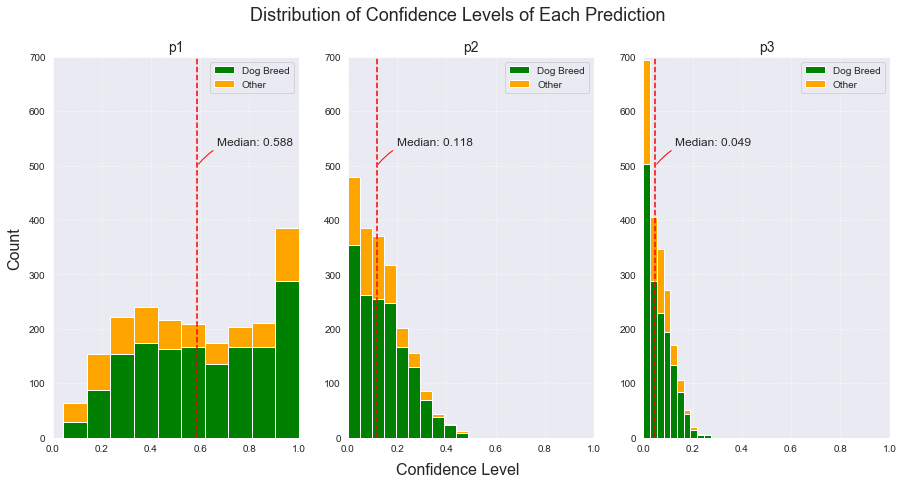

In [27]:
# create a figure with suplots arranged in 1-by-3
fig, ax = plt.subplots(nrows = 1, ncols = 3,figsize = (15, 7))

# add figure title and axis labels for all subplots
fig.suptitle('Distribution of Confidence Levels of Each Prediction', fontsize = 18)
fig.text(x = 0.5, y = 0.06, s = 'Confidence Level', ha = 'center', va = 'center', fontsize = 16)
fig.text(x = 0.09, y = 0.5, s = 'Count', ha = 'center', va = 'center', rotation = 'vertical', fontsize = 16)

# for each subplot indexed by the level of prediction, p1, p2, and p3
for i, p in enumerate(df_image.prediction.unique()):
    
    # set the level of prediction as the title of the suplot
    ax[i].set_title(label = p, fontsize = 14)
    
    # plot a stacked histogram for confidence levels of predictions
        # top: non-dog breed outputs
        # bottom: dog breed outputs
    stack_hist = ax[i].hist(x = [df_image.query('prediction == @p & dog_breed == True').confidence
                           , df_image.query('prediction == @p & dog_breed == False').confidence]
                      , histtype = 'barstacked'
                      , color = ['green', 'orange']
                      , label = ['Dog Breed', 'Other'])
    # add legend for colors    
    ax[i].legend()
    
    # set the range for both x and y axes for all suplots
    ax[i].set_xlim(xmin = 0.0, xmax = 1.0)
    ax[i].set_ylim(ymin = 0.0, ymax = 700)
    
    # calculate the median of the confidence levels
    median = df_image.query('prediction == @p').confidence.median()
    
    # plot vertical line through the median
    ax[i].axvline(x = median, c = 'r', linestyle = '--')
    
    # annotate the vertical line with the median value
    ax[i].annotate(s = 'Median: {}'.format(round(median, 3))
                   , xy = (median, 500), xycoords = 'data'
                   , xytext = (20, 20), textcoords = 'offset points'
                   , fontsize = 12, arrowprops = dict(arrowstyle = "-"
                                                      , connectionstyle = "arc3, rad=0.3"
                                                      , color = 'red'));

The three histograms illustrate that the confidence level of a prediction is expected to decrease with each prediction. The median values of the confidence levels for the first, second, and third predictions were 0.588, 0.118, and 0.049, respectively. In addition to this leftward shift of the center of the distribution, the difference in the shape of the distributions for the first and second predictions, left-skewed and right-skewed, supports the higher confidence level expected for the higher level of prediction. In fact, from the second to the third prediction, the distribution of the confidence levels become more right-skewed. 

In addition, the plots not only confirm the proximity of the mean proportion of predictions with dog breeds across the three levels of predictions but illustrate that this proximity holds for each binwidth of confidence levels across all three levels of predictions. For the majority of the bars in all three plots, the proportion of green area is larger than twice the proportion of orange area.

<a id='conclusion'></a>
## Conclusion
Before exploring the data to decide on topics or questions to investigate, review of the data imported from the cleaned datasets in the `.csv` files revealed that integer values which were stored as strings were reverted back to integers. As such, steps from data wrangling may need to be repeated depending on the data or the goals of the project.

For the first topic, exploring the data involved extracting the _hour_ and _day_ parts of datetime data by using methods from the `datetime` package. These methods required the timestamp to have a data type of datetime, a requirement met by the wrangling efforts from __Part 1__. Engineering the data for calculating the percentage of tweets from each hour in a day relied on grouping and counting values of the `day` and `hour` columns which were newly created while exploring the data.

Investigation of the second topic did not necessarily benefit from the wrangling efforts. However, the analysis and visualization of the correlation between the favorite counts and the retweet counts would not have been possible if the data type of these variables was not numeric.

For the third topic, exploring and engineering the data relied heavily on the numerator values of the dog ratings out of 10. The `rating_denominator` column was omitted from the analysis because during the wrangling phase, all ratings with denominator values other than 10 were removed. Also, fractions included in the tweets which were mistakenly identified as ratings were removed during data wrangling. Additionally, the sentiment analysis was performed for only the original tweets which were filtered based on the `retweet` column that was created during data wrangling.

Visualizing data for the first three topics did rely on wrangling to a certain degree. However, creating plots for the last topic benefited most from the results of the wrangling phase. If the non-variable column headers in the original image predictions data were not tidied, then plotting a histogram of the confidence levels for each level of prediction would have been cumbersome in that three different columns of confidence levels instead of the single `confidence` column need to be provided as the values for the _x_ axis. Also, the mean proportion of predictions with dog breeds could not have been computed by iterating through the single `dog_breed` column without the tidy data.

As mentioned in __Part 1: Data Wrangling__, the gathering, assessing, and cleaning the data defines a bulk of the overall data analysis process. However, unlike the previous part, which supported this statement by demonstrating the exhaustive nature of data wrangling, exploring and engineering the data during exploratory data analysis and data visualization demonstrated the importance of data wrangling by building on the cleaned datasets to organize and arrange data in ways which streamline the discovery of insights from data and presentation of meaningful patterns/trends. Finding insights by performing these tasks on raw data would have been significantly inefficient and futile if at all possible.